In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


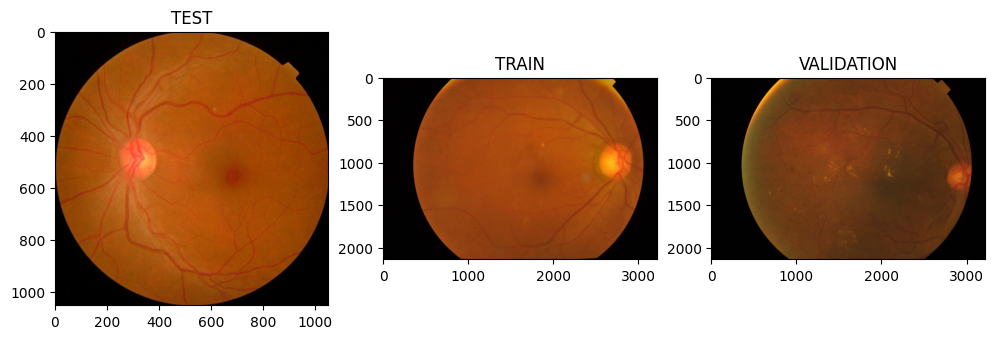

In [2]:
import matplotlib.pyplot as plt
import glob

my_path = "drive/MyDrive/5980/"
# my_path = ""
test_image_path = "./" + my_path + "APTOS/test_images/test_images"
train_image_path = "./" + my_path + "APTOS/train_images/train_images"
val_image_path = "./" + my_path + "APTOS/val_images/val_images"

test_images = sorted(glob.glob(test_image_path + '/*.png'))
train_images = sorted(glob.glob(train_image_path + '/*.png'))
val_images = sorted(glob.glob(val_image_path + '/*.png'))

test_image = test_images[0]
train_image = train_images[0]
val_image = val_images[0]

fig, ax = plt.subplots(1, 3, figsize=(12, 12))

ax[0].imshow(plt.imread(test_image), cmap='gray')
ax[0].set_title('TEST')

ax[1].imshow(plt.imread(train_image), cmap='gray')
ax[1].set_title('TRAIN')

ax[2].imshow(plt.imread(val_image), cmap='gray')
ax[2].set_title('VALIDATION')

plt.show()

In [3]:
import torch
import numpy as np

print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Device: {device}")

2.5.1+cu121
Device: cuda


In [4]:
import os
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
from functools import lru_cache

class CustomDataset(Dataset):
    def __init__(self, image_dir, labels_csv, transform=None):
        self.image_dir = image_dir
        self.labels_df = pd.read_csv(labels_csv)
        self.transform = transform

        # Normalize IDs in the labels DataFrame
        self.labels_df['id_code'] = self.labels_df['id_code'].str.lower().str.strip()

    def __len__(self):
        return len(self.labels_df)

    @lru_cache(maxsize = 10_000)
    def __getitem__(self, idx):
        # Get image ID and label
        image_id = self.labels_df.iloc[idx]['id_code']
        label = self.labels_df.iloc[idx]['diagnosis']

        # Construct image path using os.path.join for platform-independent path handling
        image_path = os.path.join(self.image_dir, f"{image_id}.png")

        # Debug: Check the file path
        # print(f"Looking for: {image_path}")
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"File not found: {image_path}")

        # Load the image
        image = Image.open(image_path)

        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)

        return image, label



Train Labels:
         id_code  diagnosis
0  1ae8c165fd53          2
1  1b329a127307          1
2  1b32e1d775ea          4
3  1b3647865779          0
4  1b398c0494d1          0
Validation Labels:
         id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0
Test Labels:
         id_code  diagnosis
0  e4dcca36ceb4          0
1  e4e343eaae2a          2
2  e4f12411fd85          4
3  e50b0174690d          0
4  e5197d77ec68          0


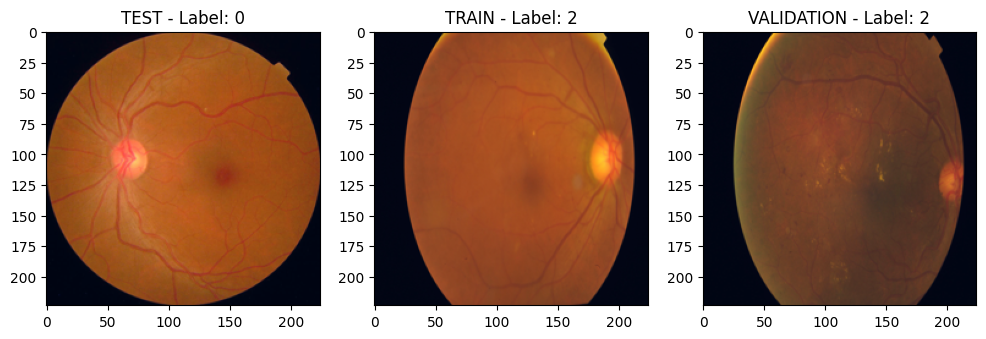

In [5]:
import pandas as pd
import glob
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import os

test_image_path = "./" + my_path + "APTOS/test_images/test_images"
train_image_path = "./" + my_path + "APTOS/train_images/train_images"
val_image_path = "./" + my_path + "APTOS/val_images/val_images"

train_csv_path = "./" + my_path + "APTOS/train_1.csv"
val_csv_path = "./" + my_path + "APTOS/valid.csv"
test_csv_path = "./" + my_path + "APTOS/test.csv"

train_labels = pd.read_csv(train_csv_path)
val_labels = pd.read_csv(val_csv_path)
test_labels = pd.read_csv(test_csv_path)

train_images = sorted(glob.glob(train_image_path + '/*.png'))
val_images = sorted(glob.glob(val_image_path + '/*.png'))
test_images = sorted(glob.glob(test_image_path + '/*.png'))

# Verify CSV content
print("Train Labels:\n", train_labels.head())
print("Validation Labels:\n", val_labels.head())
print("Test Labels:\n", test_labels.head())

transform = transforms.Compose([
    # Resize images to 819x614
    transforms.Resize((224,224),interpolation=transforms.InterpolationMode.BICUBIC),
    # Center at 600x600
    # transforms.CenterCrop(400),
    # Convert images to tensors
    transforms.ToTensor(),
    # Normalize with ImageNet mean and standard deviation ( a common practice )
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

def load_and_transform(image_path, transform):
    image = Image.open(image_path)
    transformed_image = transform(image)
    transformed_image = transformed_image.permute(1, 2, 0).numpy()
    transformed_image = (transformed_image - transformed_image.min()) / (transformed_image.max() - transformed_image.min())
    return transformed_image

def get_label(image_path, labels_df):
    image_id = os.path.splitext(os.path.basename(image_path))[0].lower().strip()
    labels_df['id_code'] = labels_df['id_code'].str.lower().str.strip()
    if image_id in labels_df['id_code'].values:
        label = labels_df.loc[labels_df['id_code'] == image_id, 'diagnosis'].values[0]
        return label
    else:
        return "Label Not Found"

train_image_transformed = load_and_transform(train_images[0], transform)
val_image_transformed = load_and_transform(val_images[0], transform)
test_image_transformed = load_and_transform(test_images[0], transform)

train_label = get_label(train_images[0], train_labels)
val_label = get_label(val_images[0], val_labels)
test_label = get_label(test_images[0], test_labels)

fig, ax = plt.subplots(1, 3, figsize=(12, 12))

ax[0].imshow(test_image_transformed)
ax[0].set_title(f'TEST - Label: {test_label}')

ax[1].imshow(train_image_transformed)
ax[1].set_title(f'TRAIN - Label: {train_label}')

ax[2].imshow(val_image_transformed)
ax[2].set_title(f'VALIDATION - Label: {val_label}')

plt.show()


In [6]:
from torch.utils.data import DataLoader

from pathlib import Path

train_dataset = CustomDataset(
    image_dir="./" + my_path + "APTOS/train_images/train_images",
    labels_csv="./" + my_path + "APTOS/train_1.csv",
    transform=transform
)

val_dataset = CustomDataset(
    image_dir="./" + my_path + "APTOS/val_images/val_images",
    labels_csv="./" + my_path + "APTOS/valid.csv",
    transform=transform
)

test_dataset = CustomDataset(
    image_dir="./" + my_path + "APTOS/test_images/test_images",
    labels_csv="./" + my_path + "APTOS/test.csv",
    transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=0)
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

In [7]:
# Manually check the first 5 images and their labels
for i in range(5):
    image, label = train_dataset[i]
    print(f"Image {i}: Label = {label}")
    print(f"Image Path: {train_dataset.image_dir}/{train_dataset.labels_df.iloc[i]['id_code']}.png")



Image 0: Label = 2
Image Path: ./drive/MyDrive/5980/APTOS/train_images/train_images/1ae8c165fd53.png
Image 1: Label = 1
Image Path: ./drive/MyDrive/5980/APTOS/train_images/train_images/1b329a127307.png
Image 2: Label = 4
Image Path: ./drive/MyDrive/5980/APTOS/train_images/train_images/1b32e1d775ea.png
Image 3: Label = 0
Image Path: ./drive/MyDrive/5980/APTOS/train_images/train_images/1b3647865779.png
Image 4: Label = 0
Image Path: ./drive/MyDrive/5980/APTOS/train_images/train_images/1b398c0494d1.png


In [8]:
from tqdm.auto import tqdm


def verify_loader_size(dataloader, dataset):
    samples = 0
    for batch, labels in tqdm(dataloader):
        samples += len(batch)
    return samples == len(dataset)

# This will take awhile as the images are loaded into memory and cached for the first time.
assert (
    verify_loader_size(train_loader, train_dataset) and
    verify_loader_size(test_loader, test_dataset) and
    verify_loader_size(valid_loader, val_dataset)
)


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [9]:
# Notice how much faster it is after caching!
assert (
    verify_loader_size(train_loader, train_dataset) and
    verify_loader_size(test_loader, test_dataset) and
    verify_loader_size(valid_loader, val_dataset)
)

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [46]:
import torch
from torch import nn, optim
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights
from timm import create_model
from torchvision.models import resnet101, ResNet101_Weights
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def initialize_model_b7(num_classes, device):
    weights = EfficientNet_B7_Weights.DEFAULT
    model = efficientnet_b7(weights=weights)
    # model = efficientnet_b7()
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model.to(device)

def initialize_model_inception(num_classes, device):
    model = create_model('inception_resnet_v2', pretrained=True)
    # model = create_model('inception_resnet_v2', pretrained=False)

    model.classif = nn.Linear(model.classif.in_features, num_classes)
    return model.to(device)

def initialize_model_resnet(num_classes, device):
    weights = ResNet101_Weights.DEFAULT
    model = resnet101(weights=weights)
    # model = resnet50()
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

def test_model(model, test_loader):
    model.eval()
    true_labels = []
    predicted_probabilities = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = nn.Softmax(dim=1)(outputs)
            true_labels.extend(labels.cpu().numpy())
            predicted_probabilities.extend(probabilities.cpu().numpy())

    return np.array(true_labels), np.array(predicted_probabilities)

def plot_learning_curves(training_losses, validation_losses):
    # Plot epoch wise training and validation losses (both in the same plot)
    assert len(training_losses) == len(validation_losses)

    # YOUR CODE HERE
    plt.figure(figsize=(10,6))
    plt.plot(training_losses, label='Training Loss', color='blue', marker='o')
    plt.plot(validation_losses, label='Validation Loss', color='orange', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()

def train_model(model, loss_module, optimizer, train_loader, valid_loader, device, path='efficientnetb7', epochs=20):
    training_losses = []
    validation_losses = []
    best_val_loss = float('inf')

    for epoch in range(epochs):

        model.train()
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Training epoch {epoch + 1}/{epochs}", leave=False, unit='batch')

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = loss_module(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        train_loss = running_loss / len(train_loader)
        training_losses.append(train_loss)

        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_module(outputs, labels)
                running_loss += loss.item()

        valid_loss = running_loss / len(valid_loader)
        validation_losses.append(valid_loss)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            torch.save({'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'epoch': epoch + 1}, f"{path}_best.pth")
            print(f"Best model saved at epoch {epoch + 1}")

        torch.save({'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'epoch': epoch + 1}, f"{path}_epoch_{epoch + 1}.pth")
    plot_learning_curves(training_losses, validation_losses)

    return training_losses, validation_losses

def evaluate_roc_auc(true_labels, predicted_probabilities):
    fpr, tpr, _ = roc_curve(true_labels, predicted_probabilities)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 5

model_b7 = initialize_model_b7(num_classes, device)
model_inception = initialize_model_inception(num_classes, device)
model_resnet = initialize_model_resnet(num_classes, device)

loss_module = nn.CrossEntropyLoss()
optimizer_b7 = optim.AdamW(model_b7.parameters(), lr=1e-4)
optimizer_inception = optim.AdamW(model_inception.parameters(), lr=1e-4)
optimizer_resnet = optim.AdamW(model_resnet.parameters(), lr=1e-4)


Training epoch 1/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 1/20, Train Loss: 0.7993, Valid Loss: 0.5486
Best model saved at epoch 1


Training epoch 2/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 2/20, Train Loss: 0.3425, Valid Loss: 0.6032


Training epoch 3/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 3/20, Train Loss: 0.1197, Valid Loss: 0.6925


Training epoch 4/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 4/20, Train Loss: 0.0820, Valid Loss: 0.7397


Training epoch 5/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 5/20, Train Loss: 0.0626, Valid Loss: 0.7356


Training epoch 6/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 6/20, Train Loss: 0.0629, Valid Loss: 0.8641


Training epoch 7/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 7/20, Train Loss: 0.0678, Valid Loss: 0.6929


Training epoch 8/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 8/20, Train Loss: 0.0421, Valid Loss: 0.8844


Training epoch 9/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 9/20, Train Loss: 0.0315, Valid Loss: 0.8860


Training epoch 10/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 10/20, Train Loss: 0.0277, Valid Loss: 0.9909


Training epoch 11/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 11/20, Train Loss: 0.0170, Valid Loss: 0.9288


Training epoch 12/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 12/20, Train Loss: 0.0066, Valid Loss: 0.9227


Training epoch 13/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 13/20, Train Loss: 0.0032, Valid Loss: 0.9648


Training epoch 14/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 14/20, Train Loss: 0.0022, Valid Loss: 0.9821


Training epoch 15/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 15/20, Train Loss: 0.0016, Valid Loss: 1.0104


Training epoch 16/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 16/20, Train Loss: 0.0014, Valid Loss: 1.0160


Training epoch 17/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 17/20, Train Loss: 0.0011, Valid Loss: 1.0350


Training epoch 18/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 18/20, Train Loss: 0.0009, Valid Loss: 1.0516


Training epoch 19/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 19/20, Train Loss: 0.0009, Valid Loss: 1.0676


Training epoch 20/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 20/20, Train Loss: 0.0008, Valid Loss: 1.0832


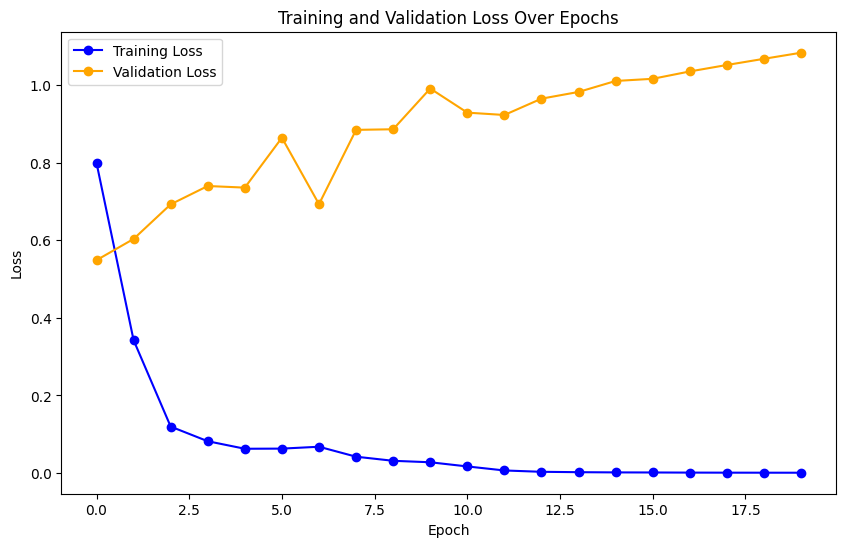

In [30]:
try:
    train_losses, val_losses = train_model(
        model_inception, loss_module, optimizer_inception, train_loader, valid_loader,
         device=device, path="inceptionnet", epochs=20
    )
except NameError:
    raise ValueError("train_loader or valid_loader is not defined. Ensure data loaders are properly initialized.")

Training epoch 1/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 1/20, Train Loss: 0.9336, Valid Loss: 1.0106
Best model saved at epoch 1


Training epoch 2/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 2/20, Train Loss: 0.5112, Valid Loss: 0.8541
Best model saved at epoch 2


Training epoch 3/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 3/20, Train Loss: 0.3049, Valid Loss: 0.5818
Best model saved at epoch 3


Training epoch 4/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 4/20, Train Loss: 0.1590, Valid Loss: 0.8743


Training epoch 5/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 5/20, Train Loss: 0.0961, Valid Loss: 0.6731


Training epoch 6/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 6/20, Train Loss: 0.0693, Valid Loss: 0.7123


Training epoch 7/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 7/20, Train Loss: 0.0483, Valid Loss: 0.6933


Training epoch 8/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 8/20, Train Loss: 0.0425, Valid Loss: 0.6490


Training epoch 9/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 9/20, Train Loss: 0.0337, Valid Loss: 0.6897


Training epoch 10/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 10/20, Train Loss: 0.0290, Valid Loss: 0.7738


Training epoch 11/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 11/20, Train Loss: 0.0198, Valid Loss: 0.8591


Training epoch 12/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 12/20, Train Loss: 0.0198, Valid Loss: 0.9411


Training epoch 13/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 13/20, Train Loss: 0.0199, Valid Loss: 1.0428


Training epoch 14/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 14/20, Train Loss: 0.0178, Valid Loss: 1.0935


Training epoch 15/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 15/20, Train Loss: 0.0173, Valid Loss: 0.8390


Training epoch 16/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 16/20, Train Loss: 0.0200, Valid Loss: 0.8589


Training epoch 17/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 17/20, Train Loss: 0.0263, Valid Loss: 0.9037


Training epoch 18/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 18/20, Train Loss: 0.0242, Valid Loss: 0.8776


Training epoch 19/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 19/20, Train Loss: 0.0186, Valid Loss: 0.9793


Training epoch 20/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 20/20, Train Loss: 0.0322, Valid Loss: 1.0671


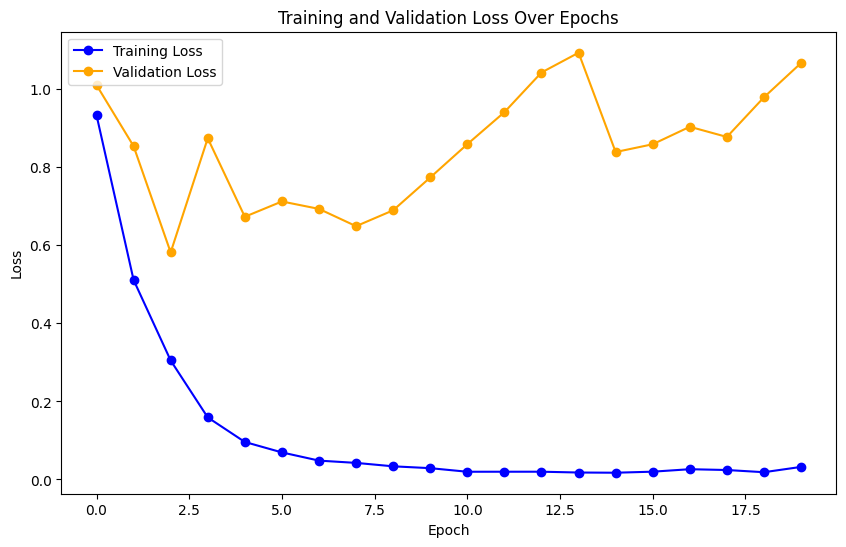

In [31]:
try:
    train_losses, val_losses = train_model(
        model_b7, loss_module, optimizer_b7, train_loader, valid_loader,
         device=device, path="efficientnetb7", epochs=20
    )
except NameError:
    raise ValueError("train_loader or valid_loader is not defined. Ensure data loaders are properly initialized.")

Training epoch 1/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 1/20, Train Loss: 0.8187, Valid Loss: 0.5750
Best model saved at epoch 1


Training epoch 2/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 2/20, Train Loss: 0.3968, Valid Loss: 0.5199
Best model saved at epoch 2


Training epoch 3/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 3/20, Train Loss: 0.1398, Valid Loss: 0.6360


Training epoch 4/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 4/20, Train Loss: 0.0688, Valid Loss: 0.8181


Training epoch 5/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 5/20, Train Loss: 0.0564, Valid Loss: 0.7543


Training epoch 6/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 6/20, Train Loss: 0.0466, Valid Loss: 0.6617


Training epoch 7/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 7/20, Train Loss: 0.0254, Valid Loss: 0.8393


Training epoch 8/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 8/20, Train Loss: 0.0213, Valid Loss: 0.7265


Training epoch 9/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 9/20, Train Loss: 0.0121, Valid Loss: 0.7784


Training epoch 10/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 10/20, Train Loss: 0.0087, Valid Loss: 0.8521


Training epoch 11/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 11/20, Train Loss: 0.0049, Valid Loss: 0.8278


Training epoch 12/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 12/20, Train Loss: 0.0036, Valid Loss: 0.8565


Training epoch 13/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 13/20, Train Loss: 0.0039, Valid Loss: 0.8715


Training epoch 14/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 14/20, Train Loss: 0.0019, Valid Loss: 0.8921


Training epoch 15/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 15/20, Train Loss: 0.0016, Valid Loss: 0.8927


Training epoch 16/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 16/20, Train Loss: 0.0011, Valid Loss: 0.9071


Training epoch 17/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 17/20, Train Loss: 0.0008, Valid Loss: 0.9217


Training epoch 18/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 18/20, Train Loss: 0.0007, Valid Loss: 0.9316


Training epoch 19/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 19/20, Train Loss: 0.0006, Valid Loss: 0.9433


Training epoch 20/20:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 20/20, Train Loss: 0.0006, Valid Loss: 0.9528


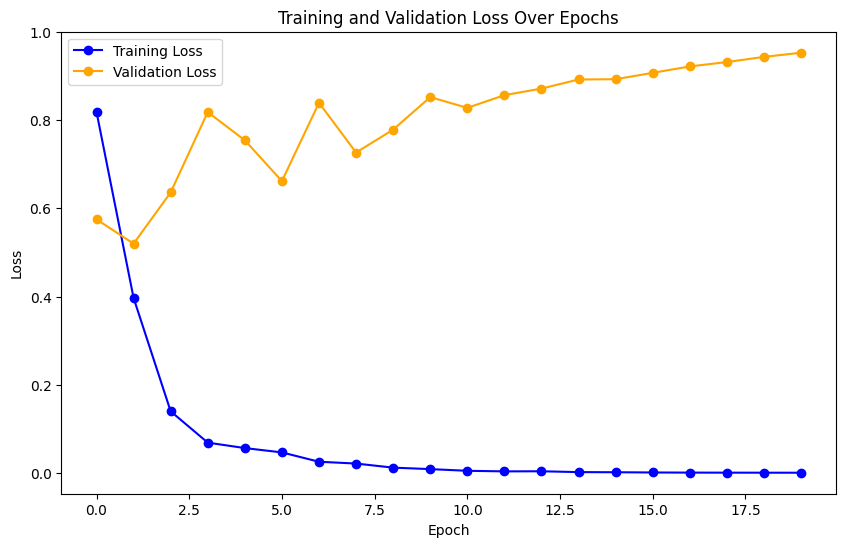

In [48]:
try:
    train_losses, val_losses = train_model(
        model_resnet, loss_module, optimizer_resnet, train_loader, valid_loader,
         device=device, path="resnet", epochs=20
    )
except NameError:
    raise ValueError("train_loader or valid_loader is not defined. Ensure data loaders are properly initialized.")

In [49]:
# Load the best model checkpoint
checkpoint_b7 = torch.load("efficientnetb7_best.pth", map_location=device)
model_b7.load_state_dict(checkpoint_b7["model_state_dict"])

checkpoint_inception = torch.load("inceptionnet_best.pth", map_location=device)
model_inception.load_state_dict(checkpoint_inception["model_state_dict"])

checkpoint_resnet = torch.load("resnet_best.pth", map_location=device)
model_resnet.load_state_dict(checkpoint_resnet["model_state_dict"])


true_labels_b7, predicted_probabilities_b7 = test_model(model_b7, test_loader)
true_labels_inception, predicted_probabilities_inception = test_model(model_inception, test_loader)
true_labels_resnet, predicted_probabilities_resnet = test_model(model_resnet, test_loader)
# roc_auc = evaluate_roc_auc(true_labels, predicted_probabilities)

def accuracy(true_labels, predicted_probabilities):
  predicted_labels = [elem.argmax() for elem in predicted_probabilities]
  correct = 0
  for i in range(len(true_labels)):
    if true_labels[i] == predicted_labels[i]:
      correct +=1
  return correct/len(true_labels)

# print(f"Test ROC-AUC: {roc_auc:.2f}")
print("Accuracy b7:", accuracy(true_labels_b7, predicted_probabilities_b7))
print("Accuracy inception:", accuracy(true_labels_inception, predicted_probabilities_inception))
print("Accuracy resnet:", accuracy(true_labels_resnet, predicted_probabilities_resnet))


<ipython-input-49-20dcf2e2d9d0>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_b7 = torch.load("efficientnetb7_best.pth", map_location=device)
<ipython-input-49

Accuracy b7: 0.8142076502732241
Accuracy inception: 0.7841530054644809
Accuracy resnet: 0.7814207650273224


In [34]:
print(f"True Labels: {set(true_labels_b7)}")  # Expect both 0 and 1
print(f"Predicted Probabilities: {predicted_probabilities_b7[:10]}")  # Should contain values between 0 and 1


True Labels: {0, 1, 2, 3, 4}
Predicted Probabilities: [[9.25546348e-01 1.88638289e-02 7.18497112e-03 3.05038616e-02
  1.79010406e-02]
 [5.23952418e-04 3.96988600e-01 5.57096243e-01 8.99631344e-03
  3.63949277e-02]
 [2.75657722e-03 4.49961200e-02 1.58102334e-01 4.54588145e-01
  3.39556813e-01]
 [9.80516732e-01 7.97459763e-03 1.60390278e-03 5.60531067e-03
  4.29940503e-03]
 [9.94882941e-01 2.01086211e-03 5.51372010e-04 1.53302553e-03
  1.02180638e-03]
 [9.87026274e-01 4.54089651e-03 7.44846417e-04 5.15386136e-03
  2.53417017e-03]
 [5.15784304e-05 2.64803832e-03 7.38986313e-01 9.39656720e-02
  1.64348468e-01]
 [3.26651311e-03 7.47162759e-01 2.38014057e-01 2.19778065e-03
  9.35888290e-03]
 [1.02657184e-01 8.62703502e-01 1.80671643e-02 4.74512717e-03
  1.18269864e-02]
 [2.49757618e-03 3.71286809e-01 6.12347841e-01 4.82966239e-03
  9.03812330e-03]]
